# <span style="color:red">3. Solution</span>

## Portfolio Management
### MLP Training

#### January 2025

Questions?
* Contact: Mark Hendricks
* hendricks@uchicago.edu

***

# 1. Mean-Variance Optimization

### Data
You will need the file in the github repo, `data/multi_asset_etf_data.xlsx`.
- The time-series data gives monthly returns for the 11 asset classes and a short-term Treasury-bill fund return, ("SHV",) which we consider as the risk-free rate.
- The data is provided in total returns, (in which case you should ignore the SHV column,) as well as excess returns, (where SHV has been subtracted from the other columns.)

### Model
We are going to analyze the problem in terms of **excess** returns.
- Be sure to use the`excess returns` tab of the data.

### Format
In the questions below, **annualize the statistics** you report, noting it is monthly data.

### 1. Summary Statistics
* Calculate and display the mean and volatility of each asset’s excess return.
* Which assets have the best and worst Sharpe ratios?

### 2. Descriptive Analysis
* Calculate the correlation matrix of the returns. Which pair has the highest correlation? And the lowest?
* How well have TIPS done in our sample? Have they outperformed domestic bonds? Foreign bonds?

### 3. The MV frontier.
* Compute and display the weights of the mean-variance optimal (tangency) portfolio.
* Does the ranking of weights align with the ranking of Sharpe ratios?
* Compute the mean, volatility, and Sharpe ratio for the tangency portfolio.

### 4. TIPS
Assess how much the tangency portfolio (and performance) change if...
* TIPS are dropped completely from the investment set.
* The expected excess monthly return to TIPS is adjusted to be `0.0012` higher than what the historic sample shows.

### 5. Bounds

Classically, allocators placed bounds on the portfolio rather than implementing whatever numbers come out of the Mean-Variance optimization problem.

What are the pros and cons of using these extra constraints?

***

In [30]:
import numpy as np
import pandas as pd
pd.options.display.float_format = "{:,.4f}".format

import matplotlib.pyplot as plt
import seaborn as sns

import statsmodels.api as sm
from sklearn.linear_model import LinearRegression

In [31]:
%matplotlib inline
plt.rcParams['figure.figsize'] = (12,6)
plt.rcParams['font.size'] = 15
plt.rcParams['legend.fontsize'] = 13

In [32]:
import sys
sys.path.insert(0, '../cmds')
from portfolio import performanceMetrics
from risk import *

In [33]:
filepath_data = '../data/multi_asset_etf_data.xlsx'
info = pd.read_excel(filepath_data,sheet_name='descriptions')
info.set_index('ticker',inplace=True)

In [34]:
rets = pd.read_excel(filepath_data,sheet_name='total returns')
rets.set_index('Date',inplace=True)
rets.drop(columns=['SHV'])

retsx = pd.read_excel(filepath_data,sheet_name='excess returns')
retsx.set_index('Date',inplace=True)

# sort columns by order of descriptions in Info tab
symbol_list = info.index.drop('SHV')
rets = rets[symbol_list]
retsx = retsx[symbol_list]

In [35]:
info

,shortName,quoteType,currency,volume,totalAssets,longBusinessSummary
ticker,,,,,,
SPY,SPDR S&P 500,ETF,USD,25604208,627773800448,The Trust seeks to achieve its investment obje...
EFA,iShares MSCI EAFE ETF,ETF,USD,10653257,54985711616,The fund generally will invest at least 80% of...
EEM,iShares MSCI Emerging Index Fun,ETF,USD,17962107,17468592128,The fund generally will invest at least 80% of...
PSP,Invesco Global Listed Private E,ETF,USD,8928,277930496,The fund generally will invest at least 90% of...
QAI,NYLI Hedge Multi-Strategy Track,ETF,USD,49257,637390272,"The fund is a ""fund of funds"" which means it i..."
HYG,iShares iBoxx $ High Yield Corp,ETF,USD,22374708,15881510912,The underlying index is a rules-based index co...
DBC,Invesco DB Commodity Index Trac,ETF,USD,478168,1387142912,The fund pursues its investment objective by i...
IYR,iShares U.S. Real Estate ETF,ETF,USD,2699001,4990495744,The fund seeks to track the investment results...
IEF,iShares 7-10 Year Treasury Bond,ETF,USD,2340833,32854654976,The underlying index measures the performance ...


In [36]:
def tangency_weights(returns,dropna=True,scale_cov=1):
    if dropna:
        returns = returns.dropna()

    covmat_full = returns.cov()
    covmat_diag = np.diag(np.diag(covmat_full))
    covmat = scale_cov * covmat_full + (1-scale_cov) * covmat_diag

    weights = np.linalg.solve(covmat,returns.mean())
    weights = weights / weights.sum()

    if returns.mean() @ weights < 0:
        weights = -weights

    return pd.DataFrame(weights, index=returns.columns)

***

### **<span style="color:red">Solution 1.1</span>**

In [37]:
mets = performanceMetrics(retsx,annualization=12)
mets.sort_values('Sharpe',ascending=False).style.format('{:.1%}')

,Mean,Vol,Sharpe,Min,Max
SPY,12.3%,15.3%,80.0%,-12.9%,12.7%
PSP,9.2%,22.4%,40.9%,-27.9%,17.8%
HYG,2.5%,7.7%,32.9%,-10.4%,6.6%
EFA,4.6%,15.3%,30.0%,-14.5%,14.3%
IYR,4.5%,17.8%,25.1%,-20.0%,11.8%
DBC,3.2%,16.8%,18.7%,-17.8%,10.2%
EEM,2.8%,17.3%,16.2%,-16.2%,15.3%
QAI,0.8%,5.2%,14.9%,-6.1%,3.6%
TIP,0.2%,5.0%,4.3%,-6.8%,4.2%
IEF,-1.2%,6.5%,-18.8%,-4.8%,4.0%


The high/low Sharpe stand out clearly:
* Highest Sharpe: `SPY`, S&P 500 equities
* Lowest Sharpe: `BWX`, international Treasury bonds (investment grade)

### **<span style="color:red">Solution 1.2</span>**

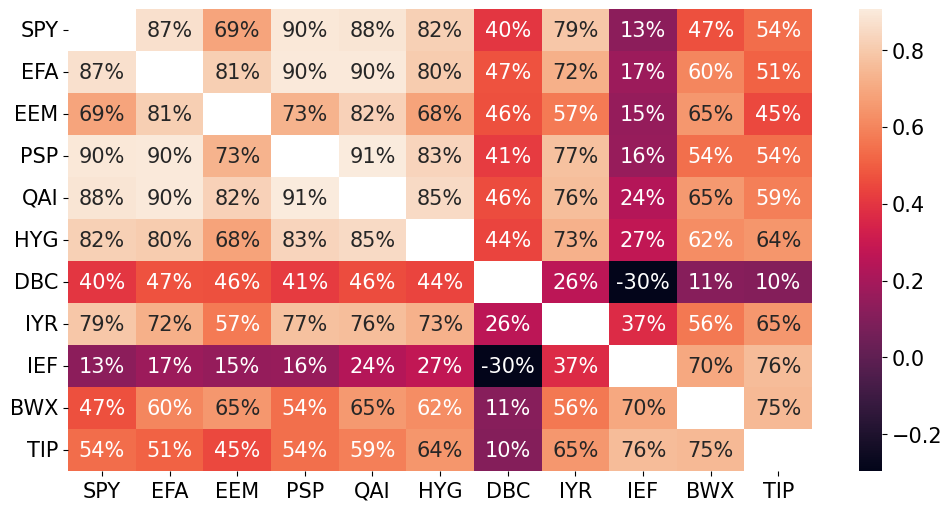

In [38]:
corrmat = retsx.corr()
corrmat[corrmat==1] = None
sns.heatmap(corrmat,annot=True,fmt='.0%');

In [39]:
corr_rank = corrmat.unstack().sort_values().dropna()
pair_max = corr_rank.index[-1]
pair_min = corr_rank.index[0]

print(f'MIN Correlation pair is {pair_min}')
print(f'MAX Correlation pair is {pair_max}')

MIN Correlation pair is ('DBC', 'IEF')
MAX Correlation pair is ('PSP', 'QAI')


### TIPS

TIPS have **substantially** outperformed both domestic bonds (`IEF`) and international bonds (`BWX`) in terms of mean, vol, and Sharpe.

* TIPS have an above-average Sharpe ratio, (relative to these 11 assets.)
* TIPS have a low mean, but a very low volatility. 

Regarding correlation,
* TIPS have low correlations to most the other assets.
* TIPS have substantial correlation to IEF and BWX. But these correlations are ~60% and 70%--well below the correlation between SPY and most the equity-based investments. 

### **<span style="color:red">Solution 1.3</span>**

In [40]:
wts = pd.DataFrame(index=retsx.columns)
wts['tangency'] = tangency_weights(retsx)

port = pd.DataFrame(retsx @ wts['tangency'],columns=['tangency'])
performanceMetrics(port,annualization=12).style.format('{:.2%}')

,Mean,Vol,Sharpe,Min,Max
tangency,8.18%,5.01%,163.27%,-3.33%,5.15%


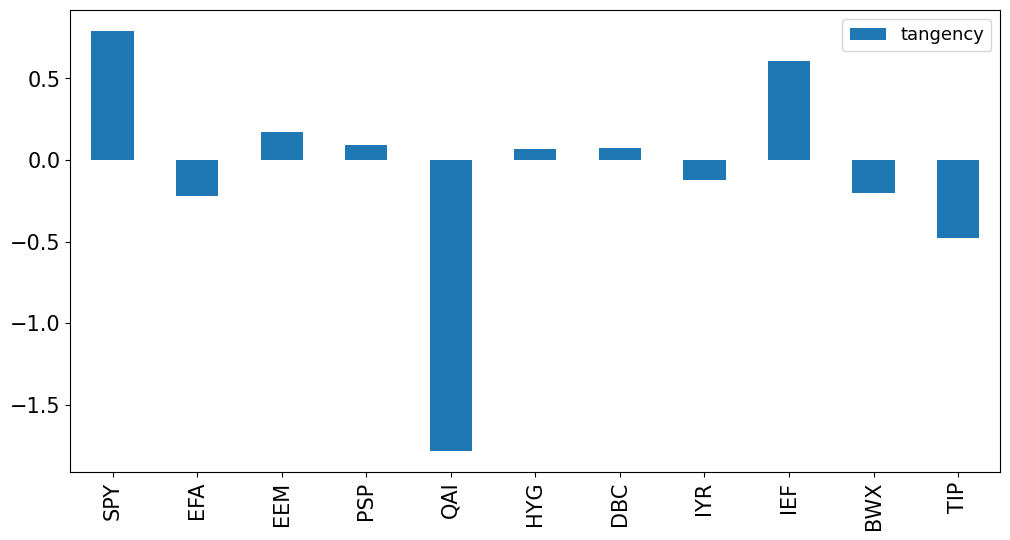

In [41]:
wts.plot.bar();

Note that the performance stats of the tangency portfolio barely change after dropping TIPS. 

Furthermore, the weights in the other assets do not change substantially from dropping TIPS.

This suggests TIPS are not substantially adding to the investment opportunity set relative to the mean-variance outcomes of the other 10 assets.

### Sharpe aligned w/ Weights?

Consider whether the Sharpe rankings align with the weight rankings...

In [42]:
pd.concat([wts['tangency'],mets['Sharpe']],axis=1).sort_values('tangency',ascending=False)

,tangency,Sharpe
SPY,0.7914,0.8000
IEF,0.6053,-0.1881
EEM,0.1745,0.1620
PSP,0.0900,0.4092
DBC,0.0745,0.1873
HYG,0.0691,0.3286
IYR,-0.1224,0.2513
BWX,-0.2014,-0.3075
EFA,-0.2222,0.2996
TIP,-0.4753,0.0425


We see that the tangency weights ranking is quite different from the Sharpe rankings. (Correlation between the two series is only about 50%.)

### **<span style="color:red">Solution 1.4</span>**

#### Weights if drop TIPS from investment set

In [43]:
wts['tangency ex tips'] = tangency_weights(retsx.drop(columns=['TIP']))
wts.loc['TIP','tangency ex tips'] = 0

#### Weights if adjust TIPS mean upward

In [44]:
TIPS_ADJ = .0012
retsx_adj = retsx.copy()
retsx_adj['TIP'] += TIPS_ADJ

wts['tan tips adj'] = tangency_weights(retsx_adj)

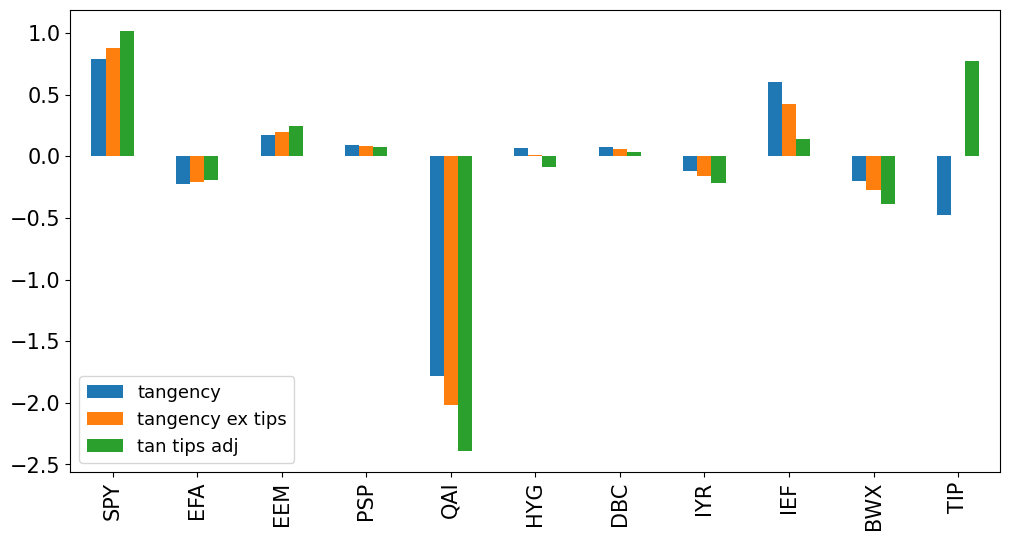

In [45]:
wts.plot.bar();

In [46]:
port['tan extips'] = pd.DataFrame(retsx @ wts['tangency ex tips'],columns=['tangency ex tips'])
port['tips adj'] = retsx_adj @ wts['tan tips adj']
performanceMetrics(port,annualization=12)

,Mean,Vol,Sharpe,Min,Max
tangency,0.0818,0.0501,1.6327,-0.0333,0.0515
tan extips,0.0928,0.0580,1.5999,-0.0372,0.0586
tips adj,0.1215,0.0741,1.6395,-0.0426,0.0709


#### Uncertainty in mean returns
Note that our adjustment to the mean return of TIPS is not so large relative to the standard error of TIPS.

In [50]:
tips_se = retsx['TIP'].std()/np.sqrt(retsx.shape[0])
print(f'Standard error of mean of TIPS is equal to {tips_se:0.2%}')

Standard error of mean of TIPS is equal to 0.13%


### Conclusions on TIPS

* Dropping TIPS from the investment set barely impacts the weights or the resulting performance.
* Adjusting the mean of TIPS upward even just 1 standard error substantially impacts the allocations and moderately boosts the resulting performance.

### **<span style="color:red">Solution 1.5.</span>**

Adding constraints...
* ensures weights that are realistic
* keeps the optimizer from doing extreme long-short portfolios
* is still easy (immediate) to solve mathematically.

However, these constraints also...
* introduce many new parameters (constraint thresholds) on which the answer is now sensitive.
* can lead to a preconceived answer by adjusting the constraints strategically.

Thus, if using constraints, it is important to...
* justify the constraints.
* measure how much they are changing the answer.

An alternative is to optimize without extra constraints but rather to use...
* regularization (including popular ML techniques such as LASSO and Ridge)
* Bayesian priors